# Prueba piloto con datos de alrededor de Justiniano Posse

La idea en esta notebook es testear modelos para intentar predecir el caudal del río en Dique Aforador, usando datos de las estaciones en Justiniano Posse y Monte Buey

In [2]:
# Load packages
import sys

import matplotlib

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from numpy import ma 
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.colors as mcolors
import os
from matplotlib import gridspec
import seaborn as sns
import re

Cargamos los datos de ERA5 por si los llegamos a necesitar

In [3]:
# ERA5-Land data
era5land_path = '/datosfreyja/d1/GDATA/ERA5-Land/'
era5land = xr.open_mfdataset(era5land_path+'*/*.nc')

Ajusto las variables acumuladas y paso a hora local

In [4]:
vars_to_adjust = ['tp', 'ro', 'sro']

era5land_adjusted = dict()
for var in list(era5land.data_vars):
    if var in vars_to_adjust:
        era5land_adjusted[var] = ( era5land[var] - era5land[var].shift({'time':1}, fill_value=0 )*(era5land['time']['time.hour']!=1) )/1000
        #se divide por mil al final de la cuenta porque estas variables de ERA5 están en 'm' y no en 'mm'
    else:
        era5land_adjusted[var] = era5land[var]

In [5]:
era5land_adjusted_ds = xr.Dataset(era5land_adjusted)

In [6]:
era5land_adjusted_ds['time'] = era5land_adjusted_ds['time'] - 3 * 3600000000000 #pasamos a hora local

In [7]:
era5land_adjusted_ds

<xarray.Dataset>
Dimensions:    (latitude: 71, longitude: 51, time: 26304)
Coordinates:
  * longitude  (longitude) float32 -66.0 -65.9 -65.8 -65.7 ... -61.2 -61.1 -61.0
  * latitude   (latitude) float32 -29.0 -29.1 -29.2 -29.3 ... -35.8 -35.9 -36.0
  * time       (time) datetime64[ns] 2018-12-31T21:00:00 ... 2021-12-31T20:00:00
Data variables:
    lai_hv     (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    lai_lv     (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl4      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>

Cargo los datos de las estaciones

In [8]:
# Cargo Lista de ubicaciones
obs_path = '/datos/julian.giles/flash_flood/datos_estaciones/'
ubicaciones = pd.read_csv(obs_path+'ubicaciones_estaciones.csv', sep=';')
ubicaciones

,nombre,lat,lon,grupo
0,Dique Aforador,-32.931762,-62.332002,1
1,Justiniano Posse,-32.895530,-62.648230,1
2,Monte Buey,-32.897552,-62.442105,1
3,Buchardo,-34.706000,-63.503000,2
4,Rio Cuarto,-33.161200,-64.357000,3
5,Alpa Corral,-32.689484,-64.720150,3
6,Ruta8,-33.138248,-64.284920,3
7,RP26,-34.762833,-63.644930,2
8,FAV - UNRC,-32.968273,-64.652778,3
9,Tincunaco,-32.903340,-64.716535,3


In [9]:
datos = dict()
files_list = os.listdir(obs_path)
for nombre in ubicaciones['nombre']:
    for file in files_list:
        if re.search("".join(nombre.split(' ')), file, flags=re.IGNORECASE):
            datos[nombre] = pd.read_csv(obs_path+file, sep=';',low_memory=False, skip_blank_lines=True).dropna(how='all')
            
            if 'Fecha' in datos[nombre].columns:
                datos[nombre] = pd.read_csv(obs_path+file, sep=';', skip_blank_lines=True, parse_dates=['Fecha'], dayfirst=True).dropna(how='all')
                
            elif 'Fecha y Hora' in datos[nombre].columns:
                datos[nombre] = pd.read_csv(obs_path+file, sep=';', skip_blank_lines=True, parse_dates=['Fecha y Hora'], dayfirst=True).dropna(how='all')
                
            else:
                datos[nombre] = pd.read_csv(obs_path+file, sep=';', skip_blank_lines=True, header=1).dropna(how='all')
                
                if 'Fecha' in datos[nombre].columns:
                    datos[nombre] = pd.read_csv(obs_path+file, sep=';', skip_blank_lines=True, header=1, parse_dates=['Fecha'], dayfirst=True).dropna(how='all')

                elif 'Fecha y Hora' in datos[nombre].columns:
                    datos[nombre] = pd.read_csv(obs_path+file, sep=';', skip_blank_lines=True, header=1, parse_dates=['Fecha y Hora'], dayfirst=True).dropna(how='all')


/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or 

Aprox desde Junio 2020. Creamos un nuevo dataframe para ir guardando los datos recortados. Pasamos los datos a horarios.

In [10]:
fromdate = '2020-06-01 00:00:00'
todate = '2021-12-31 00:00:00'

datos_2 = dict()

# IMPORTANTE: agregamos resample horario (a pesar de que ya está horario) para rellenar datos faltantes
datos_2['Dique Aforador'] = datos['Dique Aforador'].loc[(datos['Dique Aforador']['Fecha y Hora']>=fromdate) & (datos['Dique Aforador']['Fecha y Hora']<=todate)].set_index('Fecha y Hora').resample('H').mean().interpolate()

# IMPORTANTE!!!! como los datos son acumulados/promediados en el periodo anterior (los 10 min anteriores), hay que darle las opciones label='right', closed='right' para que los datos pasen a representar lo acumulado/promediado en la hora anterior
datos_2['Justiniano Posse'] = datos['Justiniano Posse'].loc[(datos['Justiniano Posse']['Fecha']>=fromdate) & (datos['Justiniano Posse']['Fecha']<=todate)].set_index('Fecha').resample('H', label='right', closed='right').mean().interpolate()
datos_2['Justiniano Posse']['Registro de Lluvia [mm]'] = datos_2['Justiniano Posse']['Registro de Lluvia [mm]']*6


datos_2['Monte Buey'] = datos['Monte Buey'].loc[(datos['Monte Buey']['Fecha']>=fromdate) & (datos['Monte Buey']['Fecha']<=todate)].set_index('Fecha').resample('H', label='right', closed='right').mean().interpolate()
datos_2['Monte Buey']['Registro de Lluvia [mm]'] = datos_2['Monte Buey']['Registro de Lluvia [mm]']*6


<AxesSubplot:xlabel='Fecha y Hora'>

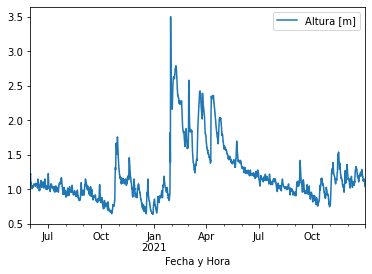

In [11]:
datos_2['Dique Aforador'].plot()

In [12]:
datos_2['Justiniano Posse'].columns

Index(['Temperatura [°C]', 'Humedad [%HR]', 'Punto de rocío [°C]',
       'Registro de Lluvia [mm]', 'Velocidad de Viento [Km/h]',
       'Direccion de Viento [°]', 'Rafaga de Viento [km/h]', 'Presion [hPa]',
       'Radiacion Solar [w/m2]', 'Temperatura de suelo [°C]',
       'Nivel de Napa Freática [cm]'],
      dtype='object')

<AxesSubplot:xlabel='Fecha'>

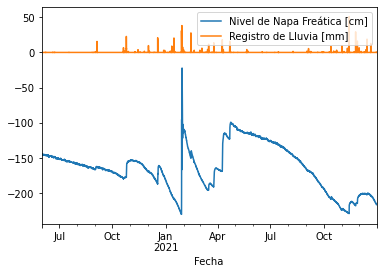

In [13]:
datos_2['Justiniano Posse'].plot( y=['Nivel de Napa Freática [cm]', 'Registro de Lluvia [mm]'])

In [14]:
datos_2['Monte Buey'].columns

Index(['Temperatura [°C]', 'Humedad [%HR]', 'Punto de rocío [°C]',
       'Registro de Lluvia [mm]', 'Velocidad de Viento [Km/h]',
       'Direccion de Viento [°]', 'Rafaga de Viento [km/h]', 'Presion [hPa]',
       'Radiacion Solar [w/m2]', 'Temperatura de suelo [°C]',
       'Nivel de Napa Freática [cm]'],
      dtype='object')

<AxesSubplot:xlabel='Fecha'>

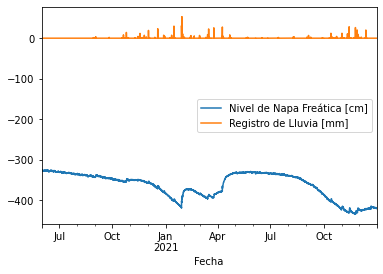

In [15]:
datos_2['Monte Buey'].plot( y=['Nivel de Napa Freática [cm]', 'Registro de Lluvia [mm]'])

### Modelos de ML

#### Baseline

Vamos a empezar sólo con lluvia y nivel de napa como features y luego ver si agregando otras variables hay mejora en el modelo

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [17]:
# Construimos nuestro dataframe de datos
target = datos_2['Dique Aforador']
data = pd.concat((datos_2['Justiniano Posse'][['Registro de Lluvia [mm]', 'Nivel de Napa Freática [cm]']], 
           datos_2['Monte Buey'][['Registro de Lluvia [mm]', 'Nivel de Napa Freática [cm]']]), axis=1)

In [18]:
# Definimos el modelo
model = make_pipeline(StandardScaler(),  LinearRegression())

In [19]:
# Hacemos un split de datos y modelamos. Calculamos los errores medios
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.25,
                                                                    random_state=0, shuffle= False)

model.fit(data_train, target_train)
target_predicted = model.predict(data_test)
mse = mean_squared_error(target_test, target_predicted)
mae = mean_absolute_error(target_test, target_predicted)

In [20]:
print('MSE: '+str(mse)+'. MAE: '+str(mae))

MSE: 0.12657042408500185. MAE: 0.29986900512785625


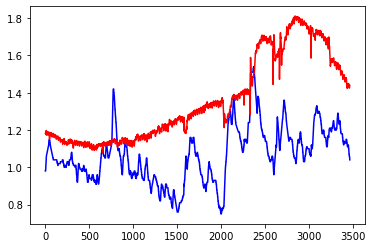

In [21]:
plt.plot(target_test['Altura [m]'].values, color= 'b'); plt.plot(target_predicted, color='r')

#### Más features

Probamos usando más las variables como features, a ver si mejora

In [22]:
data_all = pd.concat((datos_2['Justiniano Posse'][['Temperatura [°C]', 'Humedad [%HR]',
       'Registro de Lluvia [mm]', 'Velocidad de Viento [Km/h]',
       'Direccion de Viento [°]', 'Rafaga de Viento [km/h]', 'Presion [hPa]',
       'Radiacion Solar [w/m2]', 'Temperatura de suelo [°C]',
       'Nivel de Napa Freática [cm]']], 
           datos_2['Monte Buey'][['Temperatura [°C]', 'Humedad [%HR]',
       'Registro de Lluvia [mm]', 'Velocidad de Viento [Km/h]',
       'Direccion de Viento [°]', 'Rafaga de Viento [km/h]', 'Presion [hPa]',
       'Radiacion Solar [w/m2]', 'Temperatura de suelo [°C]',
       'Nivel de Napa Freática [cm]']] ), axis=1)

In [23]:
# Hacemos un split de datos y modelamos. Calculamos los errores medios
data_all_train, data_all_test, target_train, target_test = train_test_split(data_all, target, test_size=0.25,
                                                                    random_state=0, shuffle= False)

model.fit(data_all_train, target_train)
target_predicted = model.predict(data_all_test)
mse = mean_squared_error(target_test, target_predicted)
mae = mean_absolute_error(target_test, target_predicted)

In [24]:
print('MSE: '+str(mse)+'. MAE: '+str(mae))

MSE: 0.14792982731776785. MAE: 0.3214800747045618


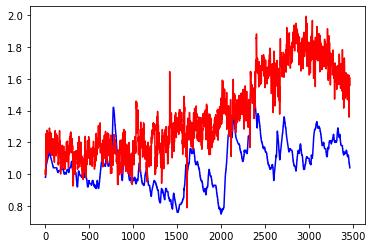

In [25]:
plt.plot(target_test['Altura [m]'].values, color= 'b'); plt.plot(target_predicted, color='r')

No hubo mejora. Hagamos otra prueba sacando algunas y dejando sólo las que creemos relevantes

In [26]:
data_all = pd.concat((datos_2['Justiniano Posse'][['Temperatura [°C]',
       'Registro de Lluvia [mm]', 'Velocidad de Viento [Km/h]', 'Presion [hPa]',
       'Radiacion Solar [w/m2]', 'Temperatura de suelo [°C]',
       'Nivel de Napa Freática [cm]']], 
           datos_2['Monte Buey'][['Temperatura [°C]',
       'Registro de Lluvia [mm]', 'Velocidad de Viento [Km/h]', 'Presion [hPa]',
       'Radiacion Solar [w/m2]', 'Temperatura de suelo [°C]',
       'Nivel de Napa Freática [cm]']] ), axis=1)

In [27]:
# Hacemos un split de datos y modelamos. Calculamos los errores medios
data_all_train, data_all_test, target_train, target_test = train_test_split(data_all, target, test_size=0.25,
                                                                    random_state=0, shuffle= False)

model.fit(data_all_train, target_train)
target_predicted = model.predict(data_all_test)
mse = mean_squared_error(target_test, target_predicted)
mae = mean_absolute_error(target_test, target_predicted)

In [28]:
print('MSE: '+str(mse)+'. MAE: '+str(mae))

MSE: 0.1615630164984179. MAE: 0.33647229472512213


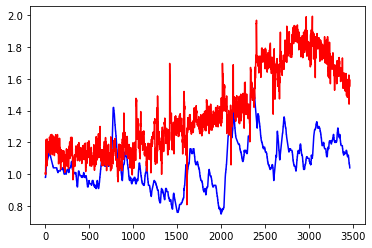

In [29]:
plt.plot(target_test['Altura [m]'].values, color= 'b'); plt.plot(target_predicted, color='r')

En principio no vemos mejoras agregando más variables. Seguimos solamente con lluvia y napa por ahora, y hacemos feature engineering

#### Feature engineering

Los valores de altura del rio actuales van a depender de los valores anteriores, veamos la autocorrelación de la altura con si misma lageada:

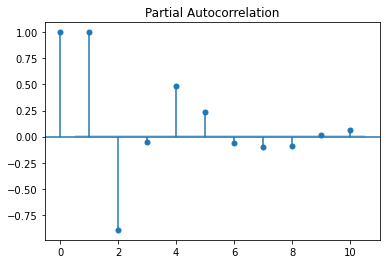

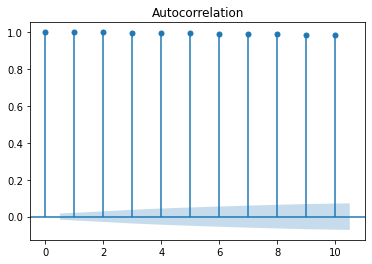

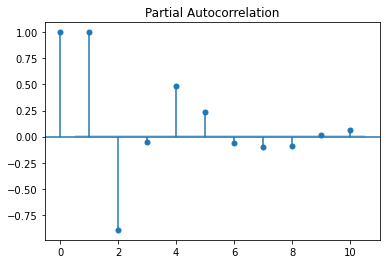

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(target, lags=10)
plot_pacf(target, lags=10)

El solo hecho de agregar la altura del río en la hora anterior debería mejorar el modelo notablemente

In [31]:
# Construimos nuestro dataframe de datos
target = datos_2['Dique Aforador']
data = pd.concat([datos_2['Justiniano Posse'][['Registro de Lluvia [mm]', 'Nivel de Napa Freática [cm]']], 
               datos_2['Monte Buey'][['Registro de Lluvia [mm]', 'Nivel de Napa Freática [cm]']] ] +
                [target.shift(n) for n in range(1,24)] , axis=1)

# tomamos desde el timestep 23 en adelante
target_shift = target.iloc[23:]
data_shift = data.iloc[23:]

MSE: 3.115201870095595e-05. MAE: 0.003952196323351753


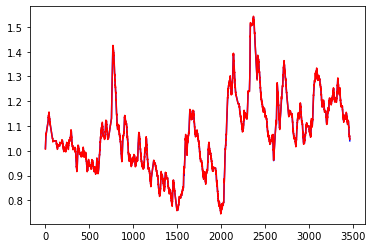

In [32]:
# Definimos el modelo
model = make_pipeline(StandardScaler(),  LinearRegression())

# Hacemos un split de datos y modelamos. Calculamos los errores medios
data_train, data_test, target_train, target_test = train_test_split(data_shift, target_shift, test_size=0.25,
                                                                    random_state=0, shuffle= False)

model.fit(data_train, target_train)
target_predicted = model.predict(data_test)
mse = mean_squared_error(target_test, target_predicted)
mae = mean_absolute_error(target_test, target_predicted)

print('MSE: '+str(mse)+'. MAE: '+str(mae))

plt.plot(target_test['Altura [m]'].values, color= 'b'); plt.plot(target_predicted, color='r')

MSE: 0.009138498214035508. MAE: 0.07771217519847677


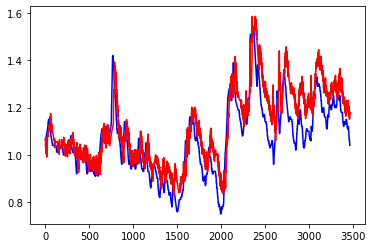

In [33]:
# Construimos nuestro dataframe de datos
target = datos_2['Dique Aforador']
data = pd.concat([datos_2['Justiniano Posse'][['Registro de Lluvia [mm]', 'Nivel de Napa Freática [cm]']], 
               datos_2['Monte Buey'][['Registro de Lluvia [mm]', 'Nivel de Napa Freática [cm]']] ] +
                [target.shift(n) for n in range(24,36)] , axis=1)

# tomamos desde el timestep 23 en adelante
target_shift = target.iloc[36:]
data_shift = data.iloc[36:]

# Definimos el modelo
model = make_pipeline(StandardScaler(),  LinearRegression())

# Hacemos un split de datos y modelamos. Calculamos los errores medios
data_train, data_test, target_train, target_test = train_test_split(data_shift, target_shift, test_size=0.25,
                                                                    random_state=0, shuffle= False)

model.fit(data_train, target_train)
target_predicted = model.predict(data_test)
mse = mean_squared_error(target_test, target_predicted)
mae = mean_absolute_error(target_test, target_predicted)

print('MSE: '+str(mse)+'. MAE: '+str(mae))

plt.plot(target_test['Altura [m]'].values, color= 'b'); plt.plot(target_predicted, color='r')

Evidentemente la altura del río no varía tanto en el intervalo de unas horas y la predicción es casi perfecta teniendo los datos anteriores

Volvamos a intentar hacer las predicciones con datos con lag y rolling de lluvia y altura de napa

In [34]:
# Construimos nuestro dataframe de datos
target = datos_2['Dique Aforador']
data = pd.concat([datos_2['Justiniano Posse'][['Registro de Lluvia [mm]', 'Nivel de Napa Freática [cm]']], 
               datos_2['Monte Buey'][['Registro de Lluvia [mm]', 'Nivel de Napa Freática [cm]']] ], axis=1)

# tomamos desde el timestep 23 en adelante, creando features lageadas y rolleadas
target_shift = target.iloc[24:]
data_shift = pd.concat([data.shift(n) for n in range(24)]+\
                       [data['Registro de Lluvia [mm]'].rolling(n).sum() for n in range(2,24)]+\
                       [data['Nivel de Napa Freática [cm]'].rolling(n).mean() for n in range(2,24)], axis=1) .iloc[24:]



MSE: 0.1500653836920651. MAE: 0.3161940337277745


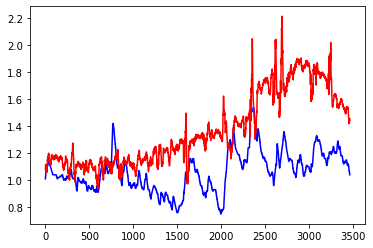

In [35]:

# Definimos el modelo
model = make_pipeline(StandardScaler(),  LinearRegression())

# Hacemos un split de datos y modelamos. Calculamos los errores medios
data_train, data_test, target_train, target_test = train_test_split(data_shift, target_shift, test_size=0.25,
                                                                    random_state=0, shuffle= False)

model.fit(data_train, target_train)
target_predicted = model.predict(data_test)
mse = mean_squared_error(target_test, target_predicted)
mae = mean_absolute_error(target_test, target_predicted)

print('MSE: '+str(mse)+'. MAE: '+str(mae))

plt.plot(target_test['Altura [m]'].values, color= 'b'); plt.plot(target_predicted, color='r')

Probamos regularizando el modelo lineal, usando Ridge

MSE: 0.13818271458820822. MAE: 0.30790910480191486


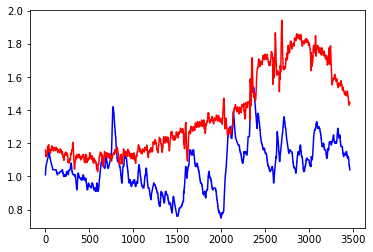

In [36]:
# Definimos el modelo
from sklearn.linear_model import Ridge

model = make_pipeline(StandardScaler(),  Ridge(alpha=100))

# Hacemos un split de datos y modelamos. Calculamos los errores medios
data_train, data_test, target_train, target_test = train_test_split(data_shift, target_shift, test_size=0.25,
                                                                    random_state=0, shuffle= False)

model.fit(data_train, target_train)
target_predicted = model.predict(data_test)
mse = mean_squared_error(target_test, target_predicted)
mae = mean_absolute_error(target_test, target_predicted)

print('MSE: '+str(mse)+'. MAE: '+str(mae))

plt.plot(target_test['Altura [m]'].values, color= 'b'); plt.plot(target_predicted, color='r')

### Probamos con otros modelos

Probemos con Random forest regressor

/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


MSE: 0.053054932799051234. MAE: 0.1870387280925831


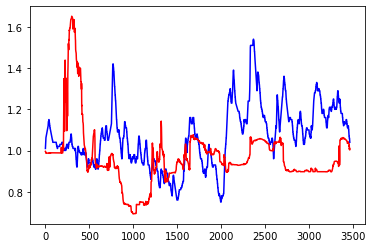

In [37]:
# Definimos el modelo
from sklearn.ensemble import RandomForestRegressor
model = make_pipeline(StandardScaler(),  RandomForestRegressor())

model.fit(data_train, target_train)
target_predicted = model.predict(data_test)
mse = mean_squared_error(target_test, target_predicted)
mae = mean_absolute_error(target_test, target_predicted)

print('MSE: '+str(mse)+'. MAE: '+str(mae))

plt.plot(target_test['Altura [m]'].values, color= 'b'); plt.plot(target_predicted, color='r')

Probamos con Support Vector Machines

/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE: 0.2927742359483881. MAE: 0.3796944907209382


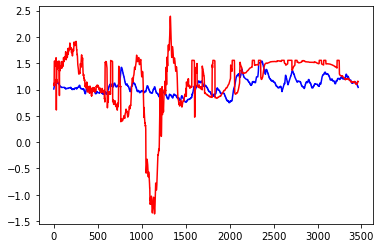

In [38]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

model = make_pipeline(StandardScaler(),  svr_rbf)

model.fit(data_train, target_train)
target_predicted = model.predict(data_test)
mse = mean_squared_error(target_test, target_predicted)
mae = mean_absolute_error(target_test, target_predicted)

print('MSE: '+str(mse)+'. MAE: '+str(mae))

plt.plot(target_test['Altura [m]'].values, color= 'b'); plt.plot(target_predicted, color='r')

Probemos ajustar los parametros de random forest

In [45]:
# probamos cual es la profundidad optima y la cantidad de arboles
from sklearn.model_selection import RandomizedSearchCV

model = make_pipeline(StandardScaler(),  RandomForestRegressor(n_jobs=5))

param_distributions = {
    'randomforestregressor__n_estimators': np.arange(20,200),
}

model_random_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=10,
    cv=[(slice(None), slice(None))], verbose=1)

model_random_search.fit(data_train, target_train)


Fitting 1 folds for each of 10 candidates, totalling 10 fits


/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/sklearn/pip

RandomizedSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(n_jobs=5))]),
                   param_distributions={'randomforestregressor__n_estimators': array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50...
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179

In [46]:
model_random_search.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=106, n_jobs=5))])

MSE: 0.053618492199958116. MAE: 0.18785108691354788


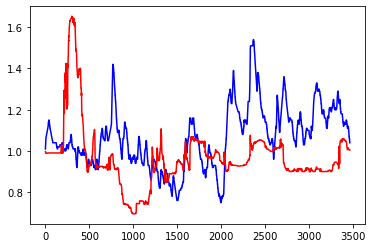

In [48]:
target_predicted = model_random_search.predict(data_test)
mse = mean_squared_error(target_test, target_predicted)
mae = mean_absolute_error(target_test, target_predicted)

print('MSE: '+str(mse)+'. MAE: '+str(mae))

plt.plot(target_test['Altura [m]'].values, color= 'b'); plt.plot(target_predicted, color='r')

El numero de arboles optimos esta cerca del default y no vemos mejora tuneando ese parametro.

#### Probemos agregando datos de ERA5

In [77]:
lugar = 'Dique Aforador'
lugar_lat = ubicaciones.loc[ubicaciones['nombre']==lugar]['lat'][0]
lugar_lon = ubicaciones.loc[ubicaciones['nombre']==lugar]['lon'][0]

era5_land_lugar = era5land_adjusted_ds.loc[{'time':slice(str(data_shift.index[0]), str(data_shift.index[-1])),
                                            'latitude':slice(lugar_lat+0.3, lugar_lat-0.3),
                                            'longitude':slice(lugar_lon-0.3, lugar_lon+0.3)}]

In [81]:
era5_land_lugar.to_dataframe()

lai_hv    lai_lv            ro  \
latitude   longitude  time                                                    
-32.700001 -62.599998 2020-06-02 00:00:00  1.200678  2.458258  0.000000e+00   
                      2020-06-02 01:00:00  1.200678  2.458258  0.000000e+00   
                      2020-06-02 02:00:00  1.200678  2.458258  0.000000e+00   
                      2020-06-02 03:00:00  1.200678  2.458258  9.909272e-10   
                      2020-06-02 04:00:00  1.200678  2.458258  0.000000e+00   
...                                             ...       ...           ...   
-33.200001 -62.099998 2021-12-30 20:00:00  2.680146  2.136363  0.000000e+00   
                      2021-12-30 21:00:00  2.680146  2.136363  0.000000e+00   
                      2021-12-30 22:00:00  2.706148  2.153582  0.000000e+00   
                      2021-12-30 23:00:00  2.706148  2.153582  0.000000e+00   
                      2021-12-31 00:00:00  2.706148  2.153582  0.000000e+00   

                                                      sp  sro     swvl1  \
latitude   longitude  time                                                
-32.700001 -62.599998 2020-06-02 00:00:00  100855.210938  0.0  0.164365   
                      2020-06-02 01:00:00  100812.484375  0.0  0.164388   
                      2020-06-02 02:00:00  100770.828125  0.0  0.164399   
                      2020-06-02 03:00:00  100753.234375  0.0  0.164410   
                      2020-06-02 04:00:00  100750.718750  0.0  0.164433   
...                                                  ...  ...       ...   
-33.200001 -62.099998 2021-12-30 20:00:00   99590.789062  0.0  0.134854   
                      2021-12-30 21:00:00   99674.968750  0.0  0.134842   
                      2021-12-30 22:00:00   99737.570312  0.0  0.134831   
                      2021-12-30 23:00:00   99774.359375  0.0  0.134808   
                      2021-12-31 00:00:00   99763.750000  0.0  0.134797   

                                              swvl2     swvl3     swvl4  \
latitude   longitude  time                                                
-32.700001 -62.599998 2020-06-02 00:00:00  0.195316  0.209211  0.228910   
                      2020-06-02 01:00:00  0.195296  0.209211  0.228910   
                      2020-06-02 02:00:00  0.195296  0.209211  0.228910   
                      2020-06-02 03:00:00  0.195286  0.209211  0.228910   
                      2020-06-02 04:00:00  0.195266  0.209211  0.228910   
...                                             ...       ...       ...   
-33.200001 -62.099998 2021-12-30 20:00:00  0.162813  0.178313  0.208279   
                      2021-12-30 21:00:00  0.162813  0.178313  0.208279   
                      2021-12-30 22:00:00  0.162791  0.178313  0.208279   
                      2021-12-30 23:00:00  0.162791  0.178313  0.208279   
                      2021-12-31 00:00:00  0.162791  0.178313  0.208279   

                                                     tp       u10       v10  
latitude   longitude  time                                                   
-32.700001 -62.599998 2020-06-02 00:00:00  0.000000e+00 -0.252681 -2.208900  
                      2020-06-02 01:00:00  0.000000e+00 -0.142075 -2.255073  
                      2020-06-02 02:00:00  0.000000e+00 -0.085866 -2.211232  
                      2020-06-02 03:00:00  0.000000e+00 -0.167823 -2.146870  
                      2020-06-02 04:00:00  0.000000e+00 -0.289671 -2.255539  
...                                                 ...       ...       ...  
-33.200001 -62.099998 2021-12-30 20:00:00  6.064773e-09  0.657204  1.949632  
                      2021-12-30 21:00:00  0.000000e+00  0.829225  1.825550  
                      2021-12-30 22:00:00  7.450581e-12  0.847923  1.959929  
                      2021-12-30 23:00:00  0.000000e+00  0.784662  2.036643  
                      2021-12-31 00:00:00  0.000000e+00  0.785285  1.958384  

[498564 rows x 12 columns]